# Marlow Case - TripleTen DS Course - Sprint 9 Project: #
# Selecting the Most Profitable Oil Well for OilyGiant via Machine Learning # 


## Contents ##
<a id='contents'></a>

- [1. Introduction](#intro)
- [2. Data Exploration](#explore)
- [3. Exploratory Data Analysis](#eda)
    - [3.1 Distribution of the Features Data](#feat_dist)
    - [3.2 Distribution of the Target Data](#targ_dist)
    - [3.3 Correlation Analysis](#corr)
- [4. Model Development](#models)
    - [4.1 Model Performance](#mod_perf)
- [5. Profit Calculations](#profit)
    - [5.1 Variable Definitions](#vars)
    - [5.2 Minimum Volume of Reserves per Oil Well without Losses](#min)
    - [5.3 Profit of Top 200 Oil Wells per Region](#200)
    - [5.4 Bootstrapping and Resulting Distributions](#boots)
- [6. Conclusion](#conclusion)

# 1. Introduction #
<a id='intro'></a>
_________________________________________________________________________________________________________________________________________________________

I have been hired by OilyGiant, the mining company, whom plans to choose a new region and develop new oil wells. They are looking to determine which region will have the highest profit margin. 

## Purpose ##
OilyGiant has provided data on oil samples from three regions, detailing various parameters for each oil well in these regions, though specific parameter definitions are not provided. The objective is to build a machine learning model to identify the region with the highest profit potential. Additionally, an analysis of potential profit and associated risks will be conducted using the _Bootstrapping_ method

## Criteria ##
This section summarizes some of the important criteria points OilyGiant is requesting for this project:
1. **Data Split:** Split the data into a training and validation set in a 75:25 ratio.
2. **Model:** Train the model using linear regression.
3. **Volume of Reserves:** Calculate the volume of reserves required to develop a new well without incurring losses. Compare this to the average reserve volume in each region.
4. **Profit Calculation:** Estimate profit based on the top 200 wells with the highest predicted reserves.
5. **Bootstrapping:** Use 1,000 bootstrap samples to determine the profit distribution.
6. **Risk Assessment:** Only consider regions with a loss risk below 2.5%; select the region with the highest average profit among these.


## Imports ##
As with previous projects, I like to keep all of my imported modules in one location organized by purpose. Those modules can be found below. 

In [1]:
# For data preprocessing
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For model buiilding and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

[Back to Contents](#contents)

# 2. Data Exploration #
<a id='explore'></a>
_________________________________________________________________________________________________________________________________________________________

To begin, I'll take a closer look at the datasets provided by OilyGiant, which contain the oil sample data from the three different regions. Let's dive in! (to the data...not the oil)

In [2]:
# Create a dictionary to store the 3 datasets
data = {}

# Create two lists containing the key names and values
regions = ['region 1', 'region 2', 'region 3']
datasets = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']

# Loop through the lists to create the dataframes
for i, region in enumerate(regions):
    try:
        data[region] = pd.read_csv(fr"C:\\Users\\marlo\\OneDrive\\Desktop\\Python_Work\\Tripleten_Lessons\\Sprint_09_Project\\{datasets[i]}")
    except:
        data[region] = pd.read_csv(f"//datasets//{datasets[i]}")

In [3]:
# Look at the first 5 rows and shape of each dataframe
for region in regions:
    print('\033[1m')
    print(region)
    display(data[region].head())
    print(f"Shape: {data[region].shape}")
    print('\033[0m')
    print('_' * 55)


region 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Shape: (100000, 5)

_______________________________________________________

region 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Shape: (100000, 5)

_______________________________________________________

region 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Shape: (100000, 5)

_______________________________________________________


It appears that each of the datasets have 100,000 rows (or oil wells) and 5 columns. 

Three of which are our features: `f0`, `f1`, and  `f2`; with the `product` being the target. The `id` field is important, as it is uniquely identifying the oil well which in the end is our goal, but it will not be a necessary field when developing our machine learning model. I will have to determine a way to exclude this field from development, but bring it back for identificaiton later on. 

**Description of the Data per OilyGiant:**

_Features:_
- `id`: the unique oil well identifier
- `f0, f1, f2`: three features of points (_their specific meaning is unimportant, but the features themselves are significant_)

_Target:_
- `product`: the volume of reserves in the oil well (thousand barrels)

In [4]:
# Check for missing values, duplicates, and data-types
for region in regions:
    print('\033[1m')
    print(region, '\n')
    print(f"Number of duplicates: {data[region].duplicated().sum()}")
    print('\033[0m')
    display(data[region].info())
    print('_' * 40)


region 1 

Number of duplicates: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________

region 2 

Number of duplicates: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________

region 3 

Number of duplicates: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________


All three of the datasets have no missing or duplicate valuesl; the data types among them are also correct.

**Descriptive Statsitcs:**

In [5]:
# Observe the descriptive statistics for each region
for region in regions:
    print('\033[1m')
    print(region, '\n')
    print('\033[0m')
    display(data[region].describe())
    print('_' * 67)


region 1 




,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


___________________________________________________________________

region 2 




,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


___________________________________________________________________

region 3 




,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


___________________________________________________________________


**_Region 1_**

The means are relatively close together with `f2` being much higher by comparison to `f0` and `f1`; The standard deviation is also higher in `f2` indiciating greater variability; as well as there appears to be a sharp increase in the value of `f2` as we reach the top 75-100% percentiles. This would indicate that this features distribution my contain some significant outliers - or a skewed distribution. 

**_Region 2_**

The means are further dispersed from eachother, but not widely, with `f2` having the highest mean with the lowest standard deviation - indicating more consistency in tis values; the extreme values are again rapidly increasing in the top 25% percentile for both `f0` and `f1` - highly exaggerated in `f1`. Difficult to come to a conclusion on what this means exactly as the specifics of these fields were not provided. It could mean these predictors are more volatile. 

**_Region 3_**

Region 3 sees the highest product mean and greatest maximum product of the three regions, not too much more than region 1; `f2` mean is greater than the others with a larger standard deviation. The extreme values increase in the top 25% percentile for each feature, `f2` being greather than the others. 

**_Overall Notes:_**

I predict that standard deviation and the mean of the features will play crucial roles in predicting their effectiveness as predictors in the model. `f2` appears to be a particularly strong predictor across all regions, given its higher mean and variability, which may capture more of the underlying patterns when developing models - greater variance could also mean noise.

[Back to Contents](#contents)

# 3. Exploratory Data Analysis (EDA) #
<a id='eda'></a>
_________________________________________________________________________________________________________________________________________________________

In [6]:
# Confirm unique wells
for region in regions:
    count = 0
    count = len(data[region]['id'].unique())
    print(f"{region}:", count)

region 1: 99990
region 2: 99996
region 3: 99996


In [7]:
for region in regions:
    duplicated_ids = data[region][data[region]['id'].duplicated(keep=False)].sort_values(by = 'id')
    print('\033[1m' + region + '\033[0m' + '\n')
    display(duplicated_ids.head(6))
    print('_' * 56, '\n')

region 1



,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504


________________________________________________________ 

region 2



,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


________________________________________________________ 

region 3



,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


________________________________________________________ 



I'm curious as to why certain wells would be tested more than once, and in most cases the results are similar, in others they are quite different: well `AGS9W` in `region 1` is an example. We do not have any context over these data points, or were given the information that each well should be unique. It's possible these tests on these wells were done under different conditions (time of day/ equipment used). Without proper context, it's difficult to decide whether each well data point should be unique. Essentially, we could leave these points as they are, or average them together. 

As stated earlier, the model will not be observing the ids of the wells, as this information does not help with its predictions, this is useful in the context of this problem. Leaving the data points in allows us to maintain all the data, the variation may be meaningful information with a risk of leaving in some noise. Since there are so few duplicated wells - I am not concerned with noise being an issue, but important to recognize. Averaging the data points allows some consistency across the features and reduces the noise, but we would lose that informative variability even if the model isn't learning the ids. 

**Therefore, I will decide to leave the data points as they are, no action is necessary to take.** 

## 3.1 Distrubtion of the Features Data ##
<a id='feat_dist'></a>

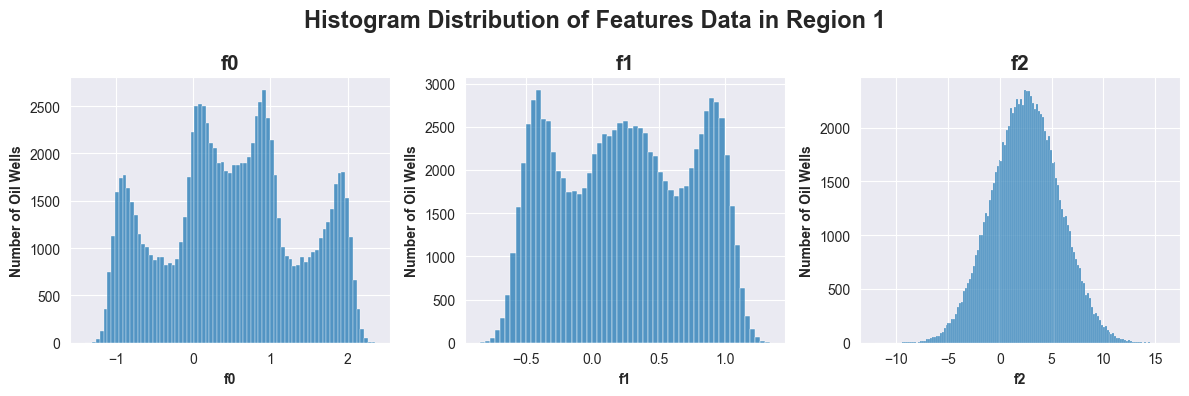

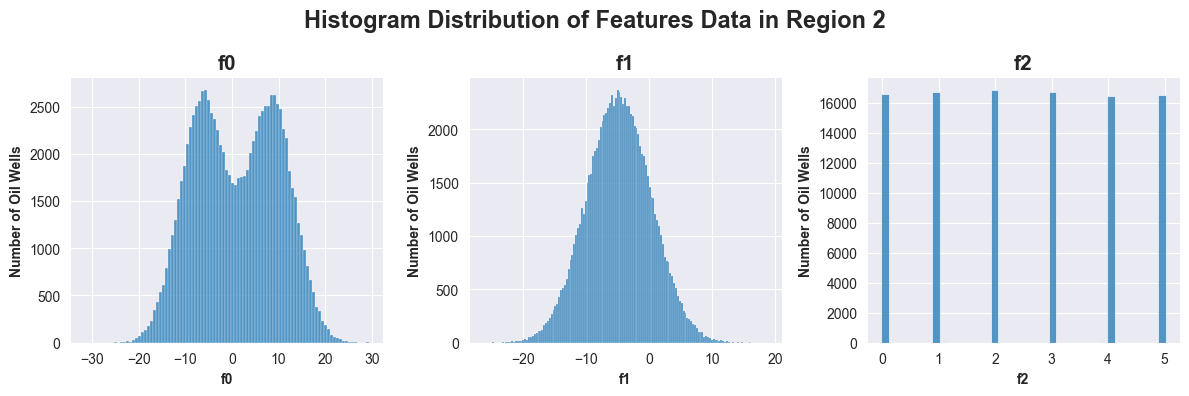

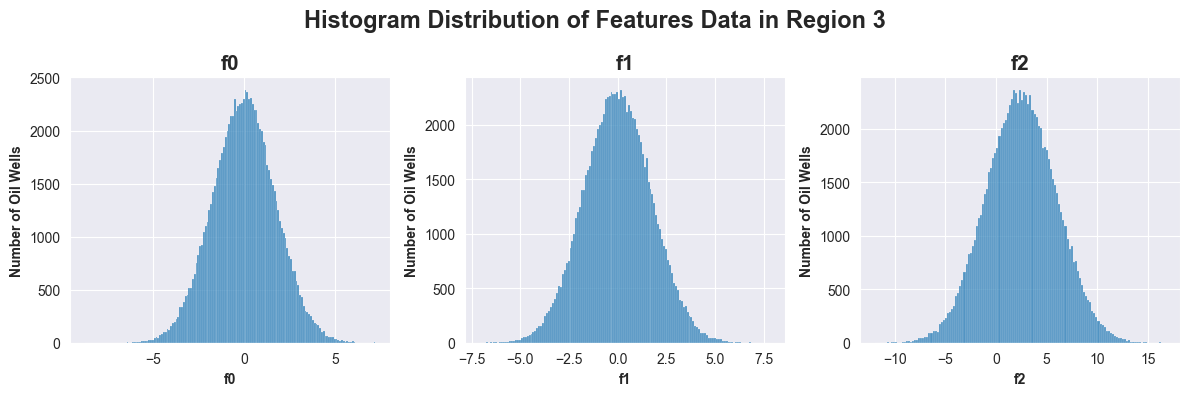

In [8]:
# Plot histograms of the features 
features = ['f0', 'f1', 'f2']

for region in regions:
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
    axs = axs.flatten()
    plt.suptitle(f"Histogram Distribution of Features Data in {region.title()}",
                  fontsize = 17, fontweight = 'bold')

    for i, (feature) in enumerate(features):
        sns.histplot(x = data[region][feature], ax=axs[i])
        axs[i].set_title(feature, fontsize = 15, fontweight = 'bold')
        axs[i].set_xlabel(feature, fontweight = 'bold')
        axs[i].set_ylabel('Number of Oil Wells', fontweight = 'bold')

    plt.tight_layout()
    plt.show()

Five of the features have normal distrubtions, the other 4 have more unique distributions. The unique distributions could indicate different subpopulations or non-linear relationships - this remphasizes again that we do not have context to these features. It's also interesting to note the symmetry present in each distribution, versus skewness. 

No action needs to be taken in regards to the non-normal distributions, but we will apply scaling when developing our model. 

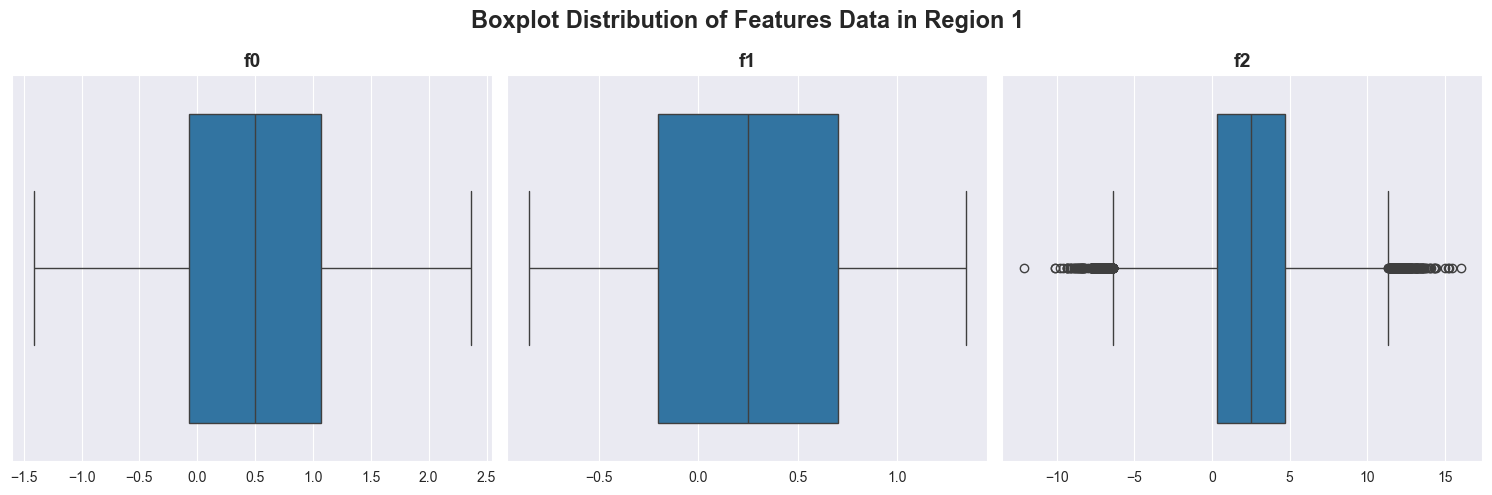

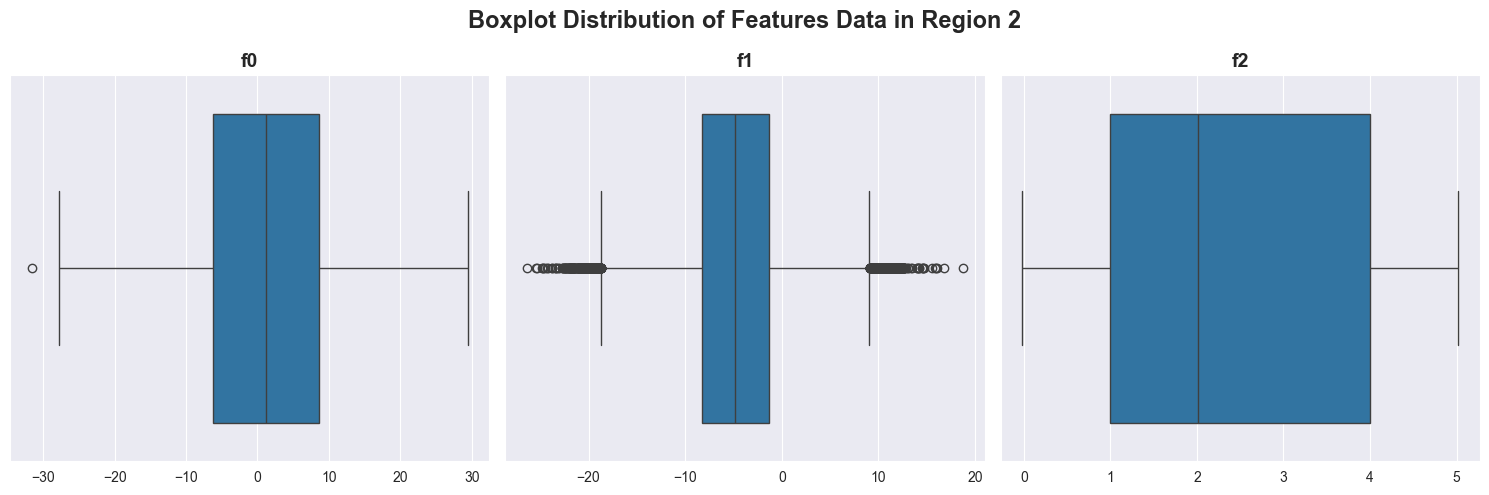

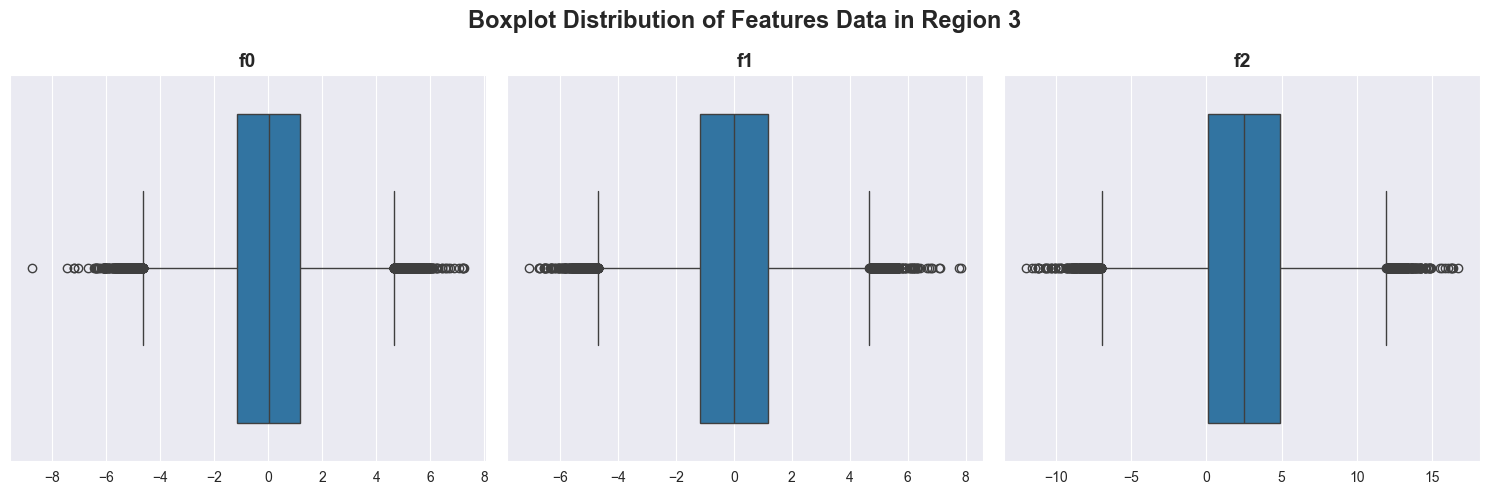

In [9]:
for region in regions:
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
    axs = axs.flatten()
    plt.suptitle(f"Boxplot Distribution of Features Data in {region.title()}",
                 fontsize = 17, fontweight = 'bold')

    for i, feature in enumerate(features):
        sns.boxplot(data = data[region], x = data[region][feature], ax = axs[i])
        axs[i].set_title(feature, fontsize = 14, fontweight = 'bold')
        axs[i].set_xlabel('')

    plt.tight_layout()
    plt.show()

**_Commentary on Outliers_**

The observed outliers are noteworthy but do not warrant further investigation at this stage. There are no indications that these outliers result from data errors; rather, they seem to be natural variations in the data. This can be expected when collecting data from oil wells. Additionally, the unique distribution types observed in the histograms might be influenced by the presence of subpopulations within the data. This could explain why the boxplots identify certain values as outliers. 

It's also intereting to note that each feature in `Region 3` has a significant amount of outliers. These outliers appear across features that exhibited normal distributions. This further supports the idea that the outliers are more likely due to natural variances rather than the presence of subpopulations. 

**_Shapes of Plots_**

The histogram for Region 2 `f2` appeared uniform, whereas the box plot is showing skewness. Whereas the rest of the boxplots show symmetry; we also get to observe the sharpness of the increase in `f2`: on a scale from 0 to 5, the top half of the data covers 2-5. Compared to the other distributions, this is by far the sharpest. 

[Back to Contents](#contents)

## 3.2 Distributions of the Target Data ##
<a id='targ_dist'></a>

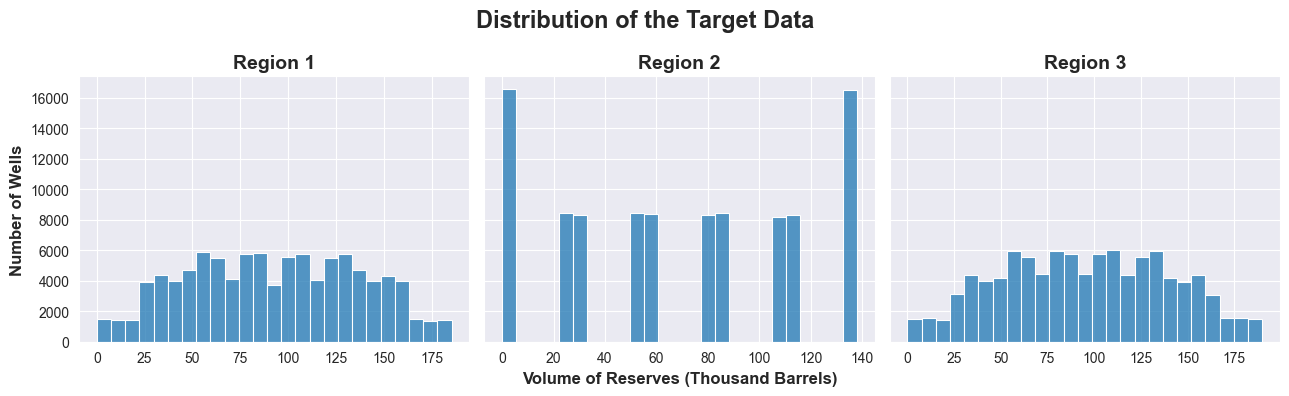

In [10]:
# Plot histograms to show the distribution of volumes
sns.set_style('darkgrid')
fig, axs = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (13,4))
axs = axs.flatten()

plt.suptitle("Distribution of the Target Data", fontsize = 17, fontweight = 'bold')

for i, region in enumerate(regions):
    sns.histplot(x = data[region]['product'], bins = 25, ax = axs[i])
    axs[i].set_title(f"{region.title()}", fontsize = 14, fontweight = 'bold')
    axs[i].set_ylabel("Number of Wells", fontsize = 12, fontweight = 'bold')
    if i == 1:
        axs[i].set_xlabel('Volume of Reserves (Thousand Barrels)', fontsize = 12, fontweight = 'bold')
    else:
        axs[i].set_xlabel('')
    
plt.tight_layout()
plt.show()

In [11]:
# Display the means
for region in regions:
    print(f"{region.title()} Mean Volume: {data[region]['product'].mean():.2f} thousand barrels")

Region 1 Mean Volume: 92.50 thousand barrels
Region 2 Mean Volume: 68.83 thousand barrels
Region 3 Mean Volume: 95.00 thousand barrels


The mean volumes of reserves in `region 1` and `region 3` are significantly greater than that of `region 2`. OilyGiant plans to choose on of the three regions and select 200 oil wells (via a study of 500 points) which have the highest possible volumes of reserves. If those oil wells are chosen randomly, `region 1` and `region 3` have the best chance to select the wells with higher volumnes. 

However, `region 2` does contain more than 16,000 oil wells that have very high volumes of reserves (about 140 thousand). Making volume predictions via machine learning will yield a higher chance to select these oil wells. Therefore, `region 2` is also a potential candidate to give a high profit.

[Back to Contents](#contents)

## 3.3 Correlation Analysis ##
<a id='corr'></a>

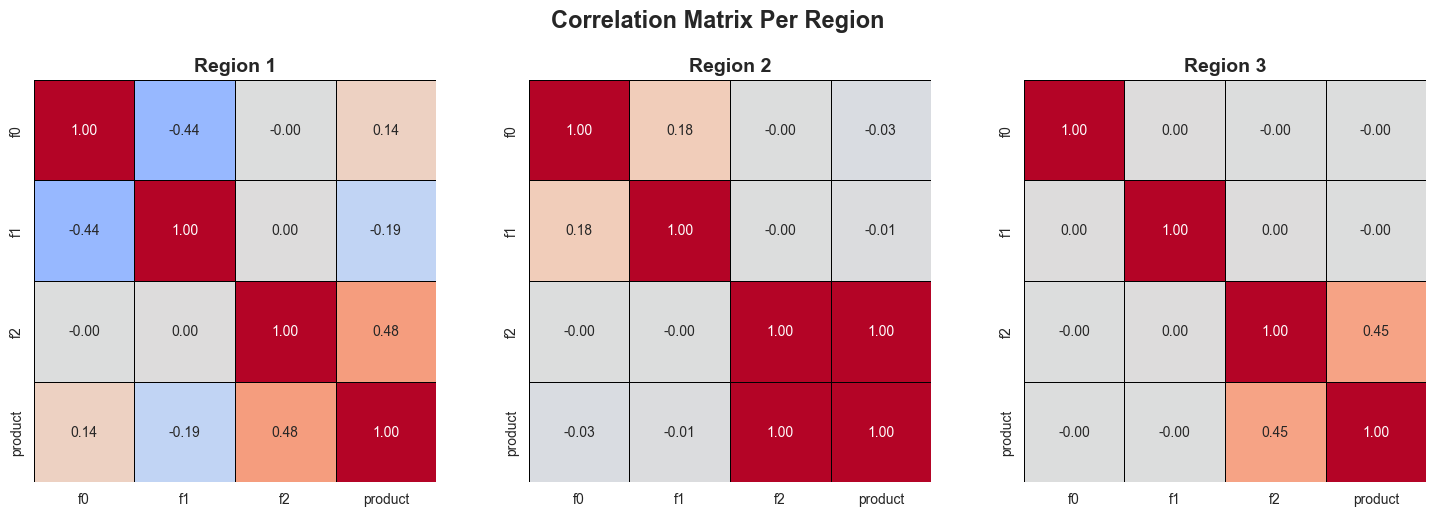

In [12]:
# Show the correlation matrix of each region
sns.set_style('darkgrid')
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axs = axs.flatten()

plt.suptitle("Correlation Matrix Per Region\n", fontsize = 17, fontweight = 'bold')

for i, region in enumerate(regions):
    sns.heatmap(data = data[region].drop(columns = 'id').corr(), 
                vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True,
                linecolor = 'black', linewidths = 0.5, cbar = False,
                square = True, fmt = '.2f', ax = axs[i])
    axs[i].set_title(region.title(), fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

We're mostly interested in the correlation between the features and the product, this data is contained in the row labeled `product`. As we can see in all regions, we have negligable correlation between the `f0` and `f1` features and `product`. In contrast, the correlation between `f2` and `product` is quite strong in all regions. In addition to this, `f0` and `f1` appear to have no impact on predicting `product` in `region 3`. 

[Back to Contents](#contents)

# 4. Model Development #
<a id='models'></a>
_________________________________________________________________________________________________________________________________________________________

The functions used below will help automate the tasks in this section. 

In [13]:
def model_train_pred_score(dataset):
    '''
    This function will split the dataset into train and validation sets;
    create and train a baseline model and a linear regression model;
    creates the predictions;
    provides metrics in the form of rmse and r2.

    It will then return the models and their metrics as well as the 
    predicted and actual volumes of oil. 
    '''

    # Separate the dataset into train and validation sets
    feat = dataset[['f0', 'f1', 'f2']] #pseudo drops id
    targ = dataset['product']

    feat_train, feat_val, targ_train, targ_val = train_test_split(
        feat, targ, test_size = 0.25, random_state = 12345)

    # Gather original indices for combined df below
    val_indices = feat_val.index

    # Scale the features
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_val = scaler.transform(feat_val)

    # Initiate, train, and predict with baseline
    # We will use mean for the dummy model; we could also play with quantile
    dumb_model = DummyRegressor()
    dumb_model.fit(feat_train, targ_train)
    dumb_pred = dumb_model.predict(feat_val)
    dumb_rmse = root_mean_squared_error(targ_val, dumb_pred)
    dumb_r2 = r2_score(targ_val, dumb_pred)

    # Initiate, train, and predict with LR
    model = LinearRegression(n_jobs = -1)
    model.fit(feat_train, targ_train)
    targ_pred = model.predict(feat_val)
    rmse = root_mean_squared_error(targ_val, targ_pred)
    r2 = r2_score(targ_val, targ_pred)

    # Build dictoinary of all results
    results = {}
    results['baseline_rmse'] = dumb_rmse
    results['rmse'] = rmse
    results['baseline_r2'] = dumb_r2
    results['r2'] = r2
    results['predicted_avg_volume'] = np.mean(targ_pred)
    results['actual_avg_volume'] = np.mean(targ_val)

    # Create a DF to return the oil well id
    data_w_id = pd.DataFrame({
        'id': dataset['id'].loc[val_indices],
        'actual_volume': targ_val.values,
        'predicted_volume': targ_pred
    })
    
    return model, results, data_w_id

In [14]:
def display_equation(model, features, region):
    '''
    This function will display the equation of a Linear Regression model.

    Parameters:
        model (LinearRegression)   - The trained linear regression model
        features (list)            - List of of the feature
        region (string)            - The region for proper labelling
    '''
    # Extract the coefficients
    coeff = model.coef_
    intercept = model.intercept_

    # Build the string
    equation = f"{region.title()} Predicted Volume = {intercept:.4f}"

    # Add features with coefficients
    for feature, coef in zip(features, coeff):
        equation += f" + ({coef:.4f} * {feature})"

    return print(equation)

Per our criteria from OilyGiant, we are to train a linear regression model to predict the volume reserves for each region. The model's performance will be based on the `root mean squared error` and the `r2 score`. A baseline model that always predicts the mean will also be trained for the sanity check. 

[Back to Contents](#contents)

## 4.1 Model Performance ##
<a id='mod_perf'></q>

In [15]:
# Create three dictionaries to store the model, model results, and combined data w/ id
model = {}
model_results = {}
model_data_w_id = {}

In [16]:
# Train the models and store the results 
for region in regions:
    model[region], model_results[region], model_data_w_id[region] = model_train_pred_score(
        data[region])

In [17]:
# Observe well information per region
for region in regions:
    print('\033[1m' + region + '\033[0m')
    display(model_data_w_id[region].head(),)
    print()

region 1


,id,actual_volume,predicted_volume
71751,7Z2gx,10.038645,95.894952
80493,b2HU8,114.551489,77.572583
2655,Y0dXD,132.603635,77.892640
53233,Mje59,169.072125,90.175134
91141,yqXxU,122.325180,70.510088



region 2


,id,actual_volume,predicted_volume
71751,aTbUt,80.859783,82.663314
80493,CK34V,53.906522,54.431786
2655,ioXCO,30.132364,29.748760
53233,xk6tF,53.906522,53.552133
91141,F9AmG,0.000000,1.243856



region 3


,id,actual_volume,predicted_volume
71751,DMlgl,61.212375,93.599633
80493,tbrRC,41.850118,75.105159
2655,JRs1w,57.776581,90.066809
53233,bidOx,100.053761,105.162375
91141,AcBBB,109.897122,115.303310


In [18]:
# Create summary
model_summary = pd.DataFrame(model_results).T
model_summary

,baseline_rmse,rmse,baseline_r2,r2,predicted_avg_volume,actual_avg_volume
region 1,44.289591,37.579422,-0.000161,0.279943,92.592568,92.078597
region 2,46.021445,0.893099,-0.000009,0.999623,68.728547,68.723136
region 3,44.902350,40.029709,-0.000012,0.205248,94.965046,94.884233


First note is that the Linear Regression model `RMSE` values are all lower than the baseline `RMSE` values, which means they are performing better than the baseline.

The `RMSE` values for regions 1 and 3 leave room for improvement compared to region 2. The value in region 2 indicates a highly accurate model, although each model predicted the `avg volume` well. 

The `R2 score` is a nice inclusion as it demonstrates that the model in region 2 explains the variability extremely well. This is good news for OilyGiant as region 2 showed excellent potential for profits, the best possible in fact, even though it has the lowest average. 

In [19]:
# Display Equations for each region
for region in model:
    display_equation(model[region], features, region)
    print()

Region 1 Predicted Volume = 92.6405 + (3.1323 * f0) + (-7.1082 * f1) + (21.4256 * f2)

Region 2 Predicted Volume = 68.8590 + (-1.2995 * f0) + (-0.1129 * f1) + (45.8860 * f2)

Region 3 Predicted Volume = 95.0386 + (0.0536 * f0) + (-0.0725 * f1) + (19.8197 * f2)



As I had predicted earlier, the volume prediction is mostly determined by the `f2` feature, but `f0` and `f1` have some impact in `region 1` as well from the equations above. 

[Back to Contents](#contents)

# 5. Profit Calculations and Risk Analysis #
<a id='profit'></a>
_________________________________________________________________________________________________________________________________________________________


## 5.1 Variable Definitions ##
<a id='vars'></a>

As informed by OilyGiant:
- When exploring the region, a study of `500 points` is carried with picking the `best 200 points` for the profit calculation.
- The `budget` for development of `200` oil wells is `100 USD Million`.
- `One barrel` of raw materials brings `4.5 USD` of revenue.
    - The revenue from `one unit` of product is `4,500 USD`.
- After the risk evaluation, keep only the regions with the risk of losses `lower than 2.5%`.  

In [20]:
# Define variables provided by OilyGiant
study_amt = 500
choose_amt = 200
budget = 100_000_000 # 1M
barrel_rev = 4.5
unit_rev = 4500
risk_thresh = 0.025

[Back to Contents](#contents)

## 5.2 Minimum Volume of Reserves (product) per Oil Well without Losses ##
<a id='min'></a>

In [21]:
# Calculate the minimum product to prevent loss
min_vol_well = budget / unit_rev / choose_amt

# Compare to predicted averages
print(f"The minimum volume of reserves per oil well without losses: {min_vol_well:.2f} \n")
display(model_summary[['predicted_avg_volume']])

The minimum volume of reserves per oil well without losses: 111.11 



,predicted_avg_volume
region 1,92.592568
region 2,68.728547
region 3,94.965046


Comparing these predicted averages to the minimum required volume, it is evident that the predictions fall short of the minimum requirement across all three regions. If OilyGiant selects 200 wells at random from any of the three regions, then they will likely incur a loss. Therefore, to optimize outcomes, OilyGiant should utilize the predictions from the machine learning model to identify and choose the 200 wells with the highest predicted volumes of reserves. 

## 5.3 Profit of Top 200 Oil Wells per Region ##
<a id='200'></a>

The function used below will help automate the tasks in this section

In [22]:
def calc_profit(df, cost = budget, amount = choose_amt, rev_per_unit = unit_rev):
    '''
    This function will help calculate the profit after selecting the top wells based on
    the predicted volume. 

    Parameters:
    df (dataframe) - the dataframe the function will use to perform the calculations
    cost (int)     - the amount OilyGiant is going to spend on the project
    amount (int)   - the maount of wells OilyGiant is going to construct
    rev_per_unit   - the amount of money OilyGiant makes per thousand barrels of product
    '''
    
    # Sort the given dataframe and select top wells
    top_wells_df = df.nlargest(amount, columns = 'predicted_volume')

    # Determine gross profit: total_volume * rev per unit
    gross_profit = top_wells_df['actual_volume'].sum() * rev_per_unit

    net_profit = gross_profit - cost
    
    return net_profit

These are the top 200 oil wells with the highest predicted volume of reserves.

In [23]:
# Use function to display profits for each region
print('\033[1m' + "For the 200 selected oil wells with the highest predicted volumes:" + '\033[0m', '\n')

for region in regions:
    prof_region = calc_profit(model_data_w_id[region])
    print(f"The profit for {region}: ${prof_region:,.2f}.")

For the 200 selected oil wells with the highest predicted volumes: 

The profit for region 1: $33,208,260.43.
The profit for region 2: $24,150,866.97.
The profit for region 3: $27,103,499.64.


From the result, all of the regions are profitable when the top 200 oil wells are selected. Specifically, `region 1` emerges as the most profitable at 33.21M USD. Therefore, I would reccommend that OilyGiant focus on developing wells in `region 1` based on the analysis. 

But this is an elementary recommendation based on a straightforward analysis via machine learning. To ensure robustness and account for variability, we should incorporate a more comprehensive risk assessment using bootstrapping techniques. We don't want OilyGiant to spend 100M USD without first assessing the risk. 

[Back to Contents](#contents)

## 5.4 Bootsrapping and Resulting Distributions ##
<a id='boots'></a>

OilyGiant has a budget of $100M for the project, and based on their criteria, they will sample 500 wells and select 200 from each sample. Using our trained machine learning model, we can predict volumes for the top 200 wells in each sample. 

Unlike our last recommendation, with bootstrapping techniques we can maximize the profits and minimize the losses. The distribution of profit for each region will be found with 1000 random samples. For each sample, we will:
1. Predict the top 200 oil wells with the highest volumes.
2. Calculate the profit based on the actual volumes of these top wells.

By analyzing the distribution of profits from these 1000 samples, we can determine:
- The 95% confidence interval of profit
- The risk of loss as a percentage of total losses. 

In [24]:
# Initiate random state and dicts to store results
np.random.seed(4496)

# store stats of each sample; store profits of each sample
sample_results = {region: {} for region in regions} # dict of stats for each region
sample_profits = {region: [] for region in regions} # list of 1000 profits per region

for region in regions:
    
    for sample in range(1000):
    
        # Create sample dataframe
        sample_df = model_data_w_id[region].sample(n = study_amt, replace = True)
    
        # Caclulate profit of sample_df and add to list
        sample_profits[region].append(calc_profit(sample_df))
    
    sample_profits[region] = pd.Series(sample_profits[region])
    
    # Calculate the resutls:
    # avg profit, confidence interval, risk of loss (probability as a percentage)
    sample_results[region]['avg_profit'] = format(sample_profits[region].mean(), ',.2f')
    sample_results[region]['CI_low'] = format(sample_profits[region].quantile(.025), ',.2f')
    sample_results[region]['CI_high'] = format(sample_profits[region].quantile(.975), ',.2f')
    sample_results[region]['risk_of_loss'] = (sample_profits[region] < 0).mean() * 100

In [25]:
# Observe the results
boot_results = pd.DataFrame(sample_results).T
boot_results

,avg_profit,CI_low,CI_high,risk_of_loss
region 1,"3,876,874.68","-747,106.53","8,773,921.01",5.3
region 2,"4,472,172.08","552,530.17","8,565,454.77",1.2
region 3,"4,041,919.64","-1,173,063.84","9,467,304.80",6.1


In [26]:
sample_profits['region 1']

0      3.954285e+05
1      2.781059e+06
2      1.228044e+05
3      3.876316e+06
4      8.531120e+05
           ...     
995    2.079236e+06
996    9.485223e+05
997    1.790140e+06
998    6.100039e+06
999    2.137218e+06
Length: 1000, dtype: float64

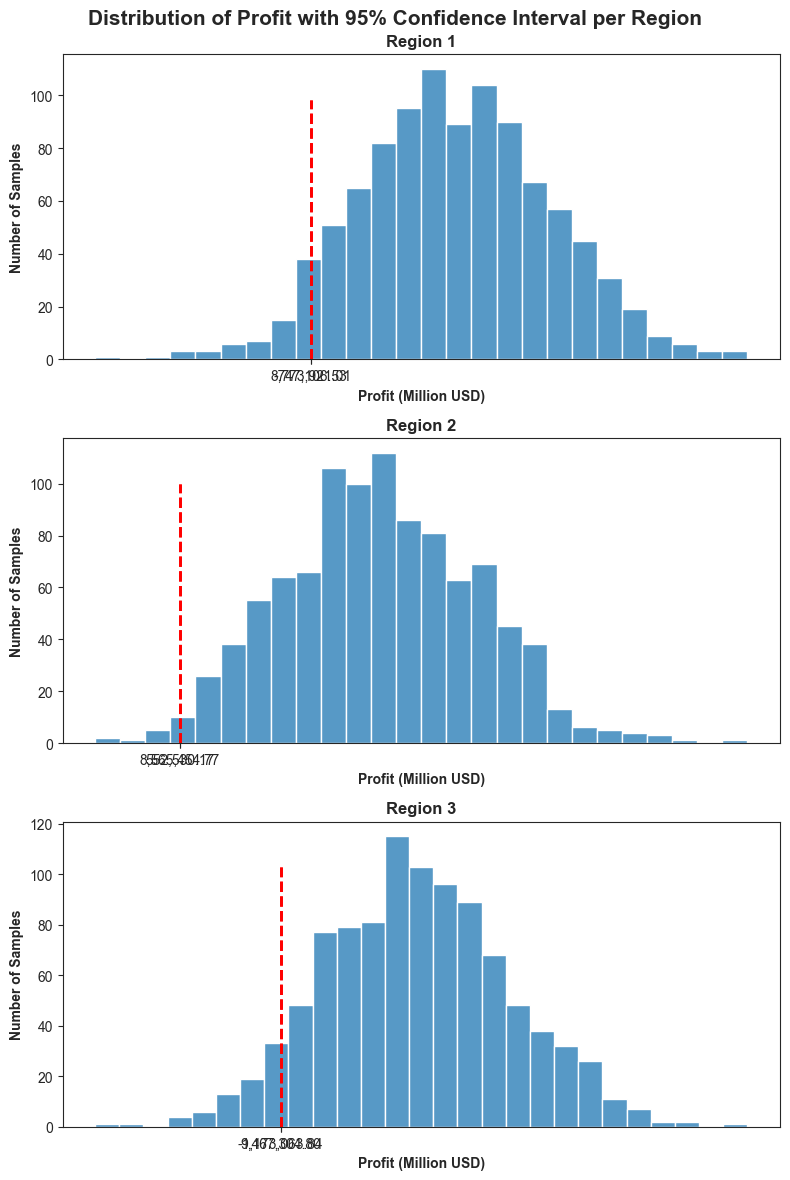

In [28]:
# Plot distribution using sample_profits
sns.set_style('ticks')
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8,12))
axs = axs.flatten()

plt.suptitle("Distribution of Profit with 95% Confidence Interval per Region",
             fontsize = 15, fontweight = 'bold')

for i, region in enumerate(regions):
    sns.histplot(x = sample_profits[region], ax = axs[i])
    axs[i].set_xlabel("Profit (Million USD)", fontweight = 'bold')
    axs[i].set_ylabel("Number of Samples", fontweight = 'bold')
    axs[i].set_title(region.title(), fontsize = 12, fontweight = 'bold')

    # Plot confidence interval
    axs[i].axvline(x = sample_results[region]['CI_low'], ymax = .85, color = 'red', 
                   linestyle = '--', label = 'CI Low', linewidth = 2)

    axs[i].axvline(x = sample_results[region]['CI_high'], ymax = 0.85, color = 'red',
                   linestyle = '--', label = 'CI High', linewidth = 2)
    
plt.tight_layout()
plt.show()


### I truly don't understand why this is graphing incorrectly. 

From the table and distributions above, `region 2` is the only region where the confidence interval contains only positive values. This is significant for OilyGiant because this means I am 95% confident that the **average profit** for selecting 200 wells in `region 2` will fall within **0.5M USD and 8.5M USD**. Additionally, the **risk of loss** being only `1.2%`. 
In contrast, `Regions 1 and 3` both contain negative values at the lower bounds of their confidence intervals; therefore, I would not recommend OilyGiant proceed in these regions as they indicate a higher risk of incurring losses. 

[Back to Contents](#contents)
# 6. Conclusion #
<a id='conclusion'></a>
_________________________________________________________________________________________________________________________________________________________

OilyGiant has tasked me to identify the most profitable of three regions to develop new oil wells. The analysis involved several steps: data exploration and preperation, model training, profit calculation and risk analysis via bootstrapping. 

**Data Exploration and Preperation:**

The provided datasets contained only a few columns: well identifier, 3 synthetic features in `f0, f1, and f2`, as well as the `target`: the `product` in thousands of barrels of volume of reserves. I was able to determine that there were no missing values and no duplicates among each dataset. I was able to identify that some wells in each dataset was tested more than once and that outliers occurred; no actions were taken in either case as there was not enough context to make a meaningful decision and having more datapoints will not hurt the model. Also, I observed that there may have been either sub-populations within the feature data or non-linear relationships; thus, a correlation analysis was performed and I found that the feature `f2` carried the most weight and was the greatest predictor of profit. 

**Model Training:**

I was instructed to use Linear Regression. So I trained the model over each region and predicted the volumes given the features. I evaluated the models' performance via $R^2$ Score and RMSE. The estimator for region 2 had the best metrics. 

**Profit Calculations:**

I began the profit calculations with the profits of the top 200 predicted wells in each region. The top 200 wells are selected based on the predicted volumes, but profit is calculated based on the actual volumes. The initial profit calculations indicated that all regions could yield profit, with `region 1` showing the highest average profit. However, this recommendation does not account for variability.  

**Risk Analysis via Bootstrapping:**

To account for the aforementioned variability, I implemented bootstrapping techniques. The parameters were set by OilyGiant: 1,000 samples and provide a 95% confidence interval for the average profit. `Region 2` emerged as the only region where the confidence interval contained positive values, indicating a very low risk of loss (**1.2%**). The average profit for `Region 2` was estimated to be between 0.5 Million USD and 8.5 Million USD, making it the most viable option for OilyGiant. Therefore, based on this bootstrapped profitability and risk analysis, **I recommend OilyGiant proceed with developing the new 200 wells in Region 2.** 